# Probabilistic Graphical Models - Homework 2
Lucas Elbert
## 2. Graphs, algorithms and Ising
### 2.1 Sum-product on an undirected chain

In [1]:
import numpy as np
from tqdm import tqdm 
    
def logscale_sum(logs):
    logs = np.array(logs)
    l_max = logs.max()
    return l_max + np.log(np.sum(np.exp(logs - l_max)))
    #assert len(logs) > 1
    #if len(logs)==2:
    #    return logscale_sum(logs[0],logs[1])
    #else:
    #    return logscale_sum(logs[-1], logscale_list_sum(logs[:-1]))
    
def all_messages(n, K, log_potentials_1, log_potentials_2):
    '''
    Computes all forward and backward messages of an undirected chain by dynamic programming
    This implementation assumes that all random variables are discrete and can only take K different values.
        args:
            n: number of nodes on the chain
            K: number of discrete values that the nodes can take
            potentials_1: function that gives the logs of all single node potentials (takes 2 parameters: the node number and its value)
            potentials_2: function that gives the logs all potentials of edges (takes four parameters: the two participating node indices and their values)
    Attention:
        potentials should be given on a log scale (ln natural logarithm)!
        messages that are returned are also on a log scale (ln natural logarithm)!
    '''

    # matrices of size (n-1,K) would suffice, only use size n to facilitate indexing
    log_forward_msg = np.zeros((n-1,K),dtype='float') # log_forward_msg[i] = msgs from i -> i+1
    log_backward_msg = np.zeros((n,K),dtype='float') # log_backward_msg[i] = msgs from i -> i-1
    
    def compute_single_msg(i, j, x_j, log_msg_to_i):
        '''
        Computes the logarithm of the msg i -> j with given x_j value
        '''
        logs = np.zeros(K)
        for x_i in range(K):
            logs[x_i] = (log_potentials_1(i,x_i) + log_potentials_2(i,j,x_i,x_j) + log_msg_to_i)
        res = logscale_sum(logs)
        #print('msg',i,'->',j,'(',x_j,') = sum(',logs,') = ',res)
        return res
    
    # Iteratively construct messages
    for i in range(n):
        for k in range(K):
            # Forward message
            # msg i -> i+1 with x_i+1 = k
            if i == n-1:
                # last node has no forward message
                pass
            else:
                if i == 0:
                    log_incoming_msg = 0
                else: 
                    log_incoming_msg = log_forward_msg[i-1, k]
                log_forward_msg[i][k] = compute_single_msg(i, i+1, k, log_incoming_msg)
            
            # Backward message
            # msg n-1-i -> n-2-i with x_n-2-i = k
            if i == n-1:
                # first node has no backward message
                pass
            else:
                if i == 0:
                    log_incoming_msg = 0
                else:
                    log_incoming_msg = log_backward_msg[n-i, k]
                log_backward_msg[n-1-i][k] = compute_single_msg(n-1-i, n-2-i, k, log_incoming_msg)
    
    return log_forward_msg, log_backward_msg
            
            
        

def all_messages_from_matrices(log_potential_1, log_potential_2):
    '''
    Wrapper for 'all_messages'. Here the potentials are given in form of np.arrays
        args:
            log_potential_1 np.array of shape (n,K)
            log_potential_2 np.array of shape (n-1,K,K) edges are indexed by the smaller node number of the participating nodes        
    '''
    n,K = log_potential_1.shape
    def log_p1(i,k):
        return log_potential_1[i,k]
    def log_p2(i,j,k_i,k_j):
        if i < j:
            return log_potential_2[i,k_i,k_j]
        else:
            return log_potential_2[j,k_j,k_i]
    return all_messages(n,K,log_p1,log_p2)

### 2.2 Exact partition function of the Ising model

In [103]:
import pickle
import matplotlib.pyplot as plt

beta = 1
w = 10
h = 100

# clusters are the rows of the grid
# a state of a cluster is the ensemble of states of its participating nodes
# As we are in the binary case we represent them by a single integer.


def log_p1(i, k, beta, bit_length):
    # cluster internal (horizontal edges)
    # bits of k represent states of internal nodes
    # beta * (count how many neighbouring bits are the same)
    compare = (k%(2**(bit_length-1)))^(k>>1)
    return beta * (bit_length - 1 - bin(compare).count('1'))
    
def log_p2(i, j, k_i, k_j, beta, bit_length):
    # cluster connecting (vertical edges)
    # beta * (count how many corresponding bits are the same)
    return beta * (bit_length - bin(k_i ^ k_j).count('1'))


K = 2**w
Zs = []
betas = []
for i in range(11):
    beta = i*0.3
    betas.append(beta)
    this_log_p1 = lambda i,k : log_p1(i,k,beta,w)
    this_log_p2 = lambda i,j,k_i,k_j : log_p2(i,j,k_i,k_j,beta,w)
    
    forwards, backwards = all_messages(h, K, this_log_p1, this_log_p2)
    Z = logscale_sum(np.array([this_log_p1(0,k)+backwards[1,k] for k in range(K)]))
    Zs.append(Z)
    print('beta',beta,'Z',Z)

with open('Zs.pkl','wb') as f:
    pickle.dump(Zs,f)

beta 0.0 Z 693.1471805599463
beta 0.3 Z 998.8027642080397
beta 0.6 Z 1368.1143161726668
beta 0.8999999999999999 Z 1813.8577519247156
beta 1.2 Z 2319.318398421477
beta 1.5 Z 2858.465403791314
beta 1.7999999999999998 Z 3413.1765914222065
beta 2.1 Z 3974.6635442712677
beta 2.4 Z 4539.116968528212
beta 2.6999999999999997 Z 5104.904499156941
beta 3.0 Z 5671.311081993601


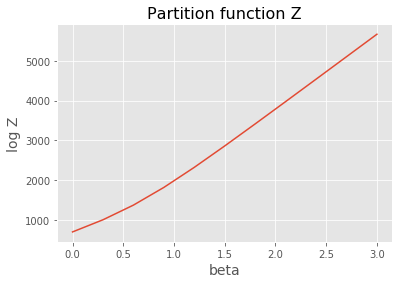

In [113]:
with open('Zs.pkl','rb') as f:
    Zs = pickle.load(f)
betas = [0.3*i for i in range(11)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(betas,Zs)
ax.set_xlabel('beta',fontsize=14)
ax.set_ylabel('log Z',fontsize=14)
ax.set_title('Partition function Z',fontsize=16)
plt.style.use('ggplot')
#fig.savefig('partition_function.png',dpi=100)